Common import header (stolen from Sensys Data.ipynb from this dir)

In [2]:
!pip install geopandas
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns 

# set the plotting style 
sns.set_style("whitegrid")
import geopandas as gpd
from shapely.geometry import Point, Polygon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.4 MB/s 
     |████████████████████████████████| 16.7 MB 62.6 MB/s 
     |████████████████████████████████| 6.3 MB 61.4 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/

/content/drive/MyDrive


In [5]:
sensloc = pd.read_csv('Sensys_location.csv')

In [6]:
sensloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16808676 entries, 0 to 16808675
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   int64  
 1   Time         object 
 2   APEG         object 
 3   Sensor Zone  object 
 4   Occup (%)    float64
 5   Vol          float64
 6   year         int64  
 7   Name         object 
 8   Latitude     float64
 9   Longitude    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.3+ GB


In [7]:
sensloc.head()

,Unnamed: 0,Time,APEG,Sensor Zone,Occup (%),Vol,year,Name,Latitude,Longitude
0,0,09/01/2021 14:00:00 PDT,apeg0125,0125S_NBT_1,16.04,115.0,2021,Ballard Bridge,47.658978,-122.376148
1,1,09/01/2021 14:05:00 PDT,apeg0125,0125S_NBT_1,9.53,74.0,2021,Ballard Bridge,47.658978,-122.376148
2,2,09/01/2021 14:10:00 PDT,apeg0125,0125S_NBT_1,7.70,66.0,2021,Ballard Bridge,47.658978,-122.376148
3,3,09/01/2021 14:15:00 PDT,apeg0125,0125S_NBT_1,4.89,47.0,2021,Ballard Bridge,47.658978,-122.376148
4,4,09/01/2021 14:20:00 PDT,apeg0125,0125S_NBT_1,6.54,56.0,2021,Ballard Bridge,47.658978,-122.376148


In [8]:
crashdf = pd.read_csv('SDOT_Collisions_-_All_Years (1).csv')

In [9]:
crashdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237176 entries, 0 to 237175
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                229433 non-null  float64
 1   Y                229433 non-null  float64
 2   OBJECTID         237176 non-null  int64  
 3   INCKEY           237176 non-null  int64  
 4   COLDETKEY        237176 non-null  int64  
 5   ADDRTYPE         233311 non-null  object 
 6   COLLISIONTYPE    205840 non-null  object 
 7   EXCEPTRSNCODE    116773 non-null  object 
 8   EXCEPTRSNDESC    12436 non-null   object 
 9   FATALITIES       237176 non-null  int64  
 10  INATTENTIONIND   30613 non-null   object 
 11  INCDATE          237176 non-null  object 
 12  INCDTTM          237176 non-null  object 
 13  INJURIES         237176 non-null  int64  
 14  INTKEY           78120 non-null   float64
 15  JUNCTIONTYPE     224616 non-null  object 
 16  LIGHTCOND        205519 non-null  obje

In [10]:
uniques = crashdf.nunique()
uniques[uniques < 100]

ADDRTYPE            3
COLLISIONTYPE      10
EXCEPTRSNCODE       2
EXCEPTRSNDESC       1
FATALITIES          6
INATTENTIONIND      1
INJURIES           16
JUNCTIONTYPE        7
LIGHTCOND           9
PEDCOUNT            7
PEDCYLCOUNT         4
PEDROWNOTGRNT       1
PERSONCOUNT        49
ROADCOND            9
SDOT_COLCODE       41
SDOT_COLDESC       41
SERIOUSINJURIES     7
SEVERITYCODE        5
SEVERITYDESC        5
SPEEDING            1
ST_COLCODE         64
ST_COLDESC         63
STATUS              2
UNDERINFL           4
VEHCOUNT           16
WEATHER            12
HITPARKEDCAR        2
dtype: int64

In [11]:
crashdf['WEATHER'] = crashdf['WEATHER'].replace('Unknown', np.nan)

In [12]:
sensorlocations = sensloc[['Name', 'Latitude', 'Longitude']].groupby(by = 'Name').max()

In [13]:
sensorlocations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 1st & Edgar Martinez to Westlake Ave N & Mercer St
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   38 non-null     float64
 1   Longitude  38 non-null     float64
dtypes: float64(2)
memory usage: 912.0+ bytes


Neat okay the labels for xy coordinates for each sensor are consistent. 

What we want is our crash dataset to have a column for the nearest sensor (NAME), as well as the sensor readings at the time closest to the crash. 

We will do this first by adding a column to the crash database for the nearest sensor, and a column for it's distance from that sensor so we can perhaps prune our crash dataset for only crashes sufficiently close to a sensor.

In [14]:
#Implimenting https://en.wikipedia.org/wiki/Haversine_formula for distance on sphere
def havsin(theta): #Haversine function
  return np.sin(theta/2)**2

def archavsin(y):
  return 2*np.arcsin(np.sqrt(y))


def distance(lat1, lon1, lat2, lon2): 
  r =  3958.8 #miles
  #r = 6378.1 #kilometers
  pphi = (lat2 + lat1)*np.pi/180.
  dphi = (lat2 - lat1)*np.pi/180.
  dlambda = (lon2 - lon1)*np.pi/180.
  havtheta = havsin(dphi) + (1-havsin(dphi) -havsin(pphi))*havsin(dlambda)
  theta = archavsin(havtheta)
  dist = r*theta
  return dist




I don't feel bad looping over our tiny dataframe of locations to add columns to our crash dataset. 

In [15]:
for sensor in sensorlocations.index.values:
  crashdf[sensor] = distance(sensorlocations.loc[sensor]['Latitude'],sensorlocations.loc[sensor]['Longitude'], crashdf['Y'], crashdf['X'])
  #print(sensorlocations.loc[sensor]['Latitude'])

In [16]:
crashdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237176 entries, 0 to 237175
Data columns (total 78 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   X                                             229433 non-null  float64
 1   Y                                             229433 non-null  float64
 2   OBJECTID                                      237176 non-null  int64  
 3   INCKEY                                        237176 non-null  int64  
 4   COLDETKEY                                     237176 non-null  int64  
 5   ADDRTYPE                                      233311 non-null  object 
 6   COLLISIONTYPE                                 205840 non-null  object 
 7   EXCEPTRSNCODE                                 116773 non-null  object 
 8   EXCEPTRSNDESC                                 12436 non-null   object 
 9   FATALITIES                                    23

In [17]:
crashdf['Nearest Sensor'] = crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'].idxmin(axis = 1)

In [18]:
crashdf['Distance'] = crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'].min(axis = 1)

In [19]:
crashdf.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,COLLISIONTYPE,EXCEPTRSNCODE,EXCEPTRSNDESC,FATALITIES,...,Highland Park Way SW at West Marginal Way SW,S Michigan St at 4th Ave S,SW Roxbury St at 15th Ave SW,South Park Bridge,Spokane St Low Bridge,Spokane St Viaduct,West Marginal Way SW at Duwamish River Trail,Westlake Ave N & Mercer St,Nearest Sensor,Distance
0,-122.264594,47.523882,1,63300,63300,Block,Parked Car,NaN,NaN,0,...,3.799783,3.376121,4.168607,2.347772,5.131289,4.630209,4.956394,7.752668,South Park Bridge,2.347772
1,-122.313029,47.670213,2,1194,1194,Block,Parked Car,,NaN,0,...,9.077666,8.661221,10.725932,9.611046,7.032076,6.882649,7.563970,3.372456,Aurora Bridge,2.271339
2,-122.270060,47.510992,3,46900,46900,Block,Parked Car,NaN,NaN,0,...,3.933720,3.654484,3.914819,2.468082,5.570359,5.149779,5.317653,8.461315,South Park Bridge,2.468082
3,-122.312719,47.655347,4,58300,58300,Block,Angles,NaN,NaN,0,...,8.066153,7.640191,9.719241,8.583971,6.043868,5.870471,6.576764,2.443359,Aurora Bridge,1.713593
4,-122.339439,47.565776,5,120500,120500,Intersection,Right Turn,NaN,NaN,0,...,1.763679,1.483458,3.406548,2.677658,0.596617,0.471394,0.627137,4.055615,1st Ave S & S Spokane St,0.449235


In [20]:
#crashdf = crashdf.drop(crashdf.loc[:,'1st & Edgar Martinez':'Westlake Ave N & Mercer St'], axis = 1)
crashdf

,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,COLLISIONTYPE,EXCEPTRSNCODE,EXCEPTRSNDESC,FATALITIES,...,Highland Park Way SW at West Marginal Way SW,S Michigan St at 4th Ave S,SW Roxbury St at 15th Ave SW,South Park Bridge,Spokane St Low Bridge,Spokane St Viaduct,West Marginal Way SW at Duwamish River Trail,Westlake Ave N & Mercer St,Nearest Sensor,Distance
0,-122.264594,47.523882,1,63300,63300,Block,Parked Car,NaN,NaN,0,...,3.799783,3.376121,4.168607,2.347772,5.131289,4.630209,4.956394,7.752668,South Park Bridge,2.347772
1,-122.313029,47.670213,2,1194,1194,Block,Parked Car,,NaN,0,...,9.077666,8.661221,10.725932,9.611046,7.032076,6.882649,7.563970,3.372456,Aurora Bridge,2.271339
2,-122.270060,47.510992,3,46900,46900,Block,Parked Car,NaN,NaN,0,...,3.933720,3.654484,3.914819,2.468082,5.570359,5.149779,5.317653,8.461315,South Park Bridge,2.468082
3,-122.312719,47.655347,4,58300,58300,Block,Angles,NaN,NaN,0,...,8.066153,7.640191,9.719241,8.583971,6.043868,5.870471,6.576764,2.443359,Aurora Bridge,1.713593
4,-122.339439,47.565776,5,120500,120500,Intersection,Right Turn,NaN,NaN,0,...,1.763679,1.483458,3.406548,2.677658,0.596617,0.471394,0.627137,4.055615,1st Ave S & S Spokane St,0.449235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237171,-122.328079,47.604161,237172,328377,329877,Intersection,Left Turn,,NaN,0,...,4.460417,4.063578,6.111042,5.091127,2.467947,2.265862,2.998837,1.481613,5th Ave S & Washington St,0.227468
237172,-122.387195,47.546683,237173,327455,328955,Intersection,Pedestrian,,NaN,0,...,2.138604,2.687573,2.565496,3.590151,2.461857,3.010917,2.008750,5.837666,35th Ave SW at SW Raymond St,0.517064
237173,-122.349214,47.614972,237174,326877,328377,Block,Parked Car,,NaN,0,...,5.167724,4.896023,6.745626,6.025226,3.011014,3.074596,3.522318,0.830036,2nd Ave & Blanchard St,0.255917
237174,-122.317886,47.710770,237175,327022,328522,Block,Other,,NaN,0,...,11.831581,11.441979,13.463875,12.414694,9.739448,9.643674,10.266045,6.038079,Ballard Bridge,4.488869


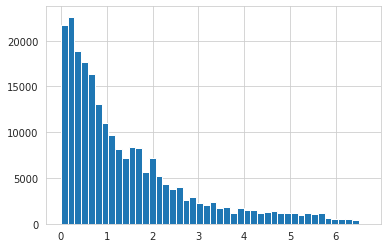

In [21]:
crashdf['Distance'].hist(bins = 45)

Now that we have each crash associated with the nearest sensor, we can also set up some functions for plotting crashes in their proximity easier

In [22]:
def loclims(sensor): #using approximations for half mile radius cus I'm too lazy to do the trig rn
  xmin = sensorlocations[sensor]['Longitude'] - 1./109.2
  ymin = sensorlocations[sensor]['Latitude'] - 1./138.
  xmax = sensorlocations[sensor]['Longitude'] + 1./109.2
  ymax = sensorlocations[sensor]['Latitude'] + 1./138.
  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])

In [23]:
# Dataset is available as crash sensor
crashdf.to_csv('crashSensor.csv', sep='\t')

In [24]:
ls

 2021_Traffic_Report_ADA_21522.pdf
'Colab Notebooks'/
'Copy of DATA 5100 Problem Statement_Edited.docx'
 crashSensor
 crashSensor.csv
 map.html
'Meeting for 10_21 .docx'
'SDOT_Collisions_-_All_Years (1).csv'
'SDOT_Collisions_-_All_Years (1).gsheet'
 Sensys_location.csv
'Street_Network_Database_(SND)'/
'Street_Network_Database_(SND).shp'


# Extendibility of traffic volume at range

To see how well the traffic indicator at a given sensor would predict traffic in the surrounding area, we will look at the time correlation between the sensors themselves. If our hypothesis is true that we should be able to use traffic data from a sensor to infer traffic volume at a distance, we should see correlation between the sensors themselves. 

In [25]:
sensloc['Time'] = sensloc['Time'].apply(lambda x : pd.Timestamp(x))

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


KeyboardInterrupt: ignored

# Data Cleaning

Vehicle Count : Continuous
Weather : Categorical
Light Condition: Categorical
Road Condition: Categorical
Location: Categorical

In [ ]:
crashdf['WEATHER'] = crashdf['WEATHER'].replace('Unknown', np.nan)
crashdf['ROADCOND'] = crashdf['ROADCOND'].replace('Unknown', np.nan)
crashdf['LIGHTCOND'] = crashdf['LIGHTCOND'].replace('Unknown', np.nan)

In [ ]:
cleancrash = crashdf[crashdf['WEATHER'].notna()]
cleancrash = cleancrash[cleancrash['ROADCOND'].notna()]
cleancrash = cleancrash[cleancrash['LIGHTCOND'].notna()]
cleancrash = cleancrash[cleancrash['JUNCTIONTYPE'].notna()]

In [ ]:
cleancrash.info()